In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If 

In [2]:
# Load the data with outliers 
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,zip_code
223586,12050.0,36,10.99,394.45,B4,MORTGAGE,40000.0,Not Verified,Fully Paid,debt_consolidation,26.79,10.0,0.0,19039.0,76.5,25.0,INDIVIDUAL,5.0,813
223587,28800.0,36,13.65,979.43,C1,RENT,108000.0,Source Verified,Fully Paid,debt_consolidation,21.92,14.0,0.0,30212.0,91.6,27.0,INDIVIDUAL,0.0,70466
223588,13000.0,60,8.90,269.23,A5,MORTGAGE,46000.0,Verified,Fully Paid,debt_consolidation,1.54,9.0,0.0,1076.0,6.6,22.0,INDIVIDUAL,2.0,22690
223589,10000.0,36,11.99,332.10,B3,OWN,70000.0,Not Verified,Charged Off,credit_card,14.71,15.0,0.0,8143.0,50.3,24.0,INDIVIDUAL,0.0,30723
223590,6400.0,36,12.99,215.62,B5,MORTGAGE,55000.0,Source Verified,Fully Paid,debt_consolidation,31.86,19.0,0.0,19322.0,51.4,21.0,INDIVIDUAL,1.0,29597


In [5]:
len(test_data.columns), len(train_data.columns)

(19, 19)

In [6]:
train_data.shape, test_data.shape

((223591, 19), (112456, 19))

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223591 entries, 0 to 223590
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            223591 non-null  float64
 1   term (months)        223591 non-null  int64  
 2   int_rate             223591 non-null  float64
 3   installment          223591 non-null  float64
 4   sub_grade            223591 non-null  object 
 5   home_ownership       223591 non-null  object 
 6   annual_inc           223591 non-null  float64
 7   verification_status  223591 non-null  object 
 8   loan_status          223591 non-null  object 
 9   purpose              223591 non-null  object 
 10  dti                  223591 non-null  float64
 11  open_acc             223591 non-null  float64
 12  pub_rec              223591 non-null  float64
 13  revol_bal            223591 non-null  float64
 14  revol_util           223591 non-null  float64
 15  total_acc        

In [8]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
train_data['Label'] = train_data[target_column].map(class_mapping)
test_data['Label'] = test_data[target_column].map(class_mapping)

In [9]:
print(train_data.shape)
train_data['Label'].value_counts(normalize=True) * 100


(223591, 20)


Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64

In [10]:
print(test_data.shape)
test_data['Label'].value_counts(normalize=True) * 100

(112456, 20)


Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64

 Leaving 'term (months)' as a number 

In [11]:
train_data = train_data.drop('loan_status', axis = 1)
test_data = test_data.drop('loan_status', axis = 1)

In [12]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type']

In [13]:
for column in categorical_columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'application_type' has 3 unique values.


TODO : since home_ownership, verification_status, purpose and application_type have less than neary 10 categories we will use one hot encodign on them
target encoding for sub_grade and addr_state


In [14]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', 'zip_code', 'sub_grade', 'purpose']

# cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type']
# cat_target_encoding = ['addr_state', 'sub_grade', 'purpose']



In [15]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,zip_code,Label
0,7000.0,36,8.99,222.57,B1,RENT,154000.0,Source Verified,credit_card,23.88,16.0,0.0,91725.0,62.2,48.0,INDIVIDUAL,2.0,5113,0
1,2000.0,36,11.53,65.99,B5,RENT,41600.0,Not Verified,debt_consolidation,26.49,11.0,0.0,3541.0,20.1,16.0,INDIVIDUAL,0.0,22690,0
2,24000.0,60,12.39,538.61,C1,MORTGAGE,120000.0,Source Verified,debt_consolidation,19.01,13.0,0.0,38065.0,79.0,34.0,INDIVIDUAL,1.0,48052,0
3,15575.0,60,17.57,391.87,D2,MORTGAGE,62000.0,Source Verified,debt_consolidation,26.06,9.0,0.0,15089.0,74.7,23.0,INDIVIDUAL,5.0,48052,1
4,12000.0,36,12.69,402.54,C2,RENT,36000.0,Source Verified,debt_consolidation,34.67,18.0,0.0,5681.0,38.6,28.0,INDIVIDUAL,0.0,86630,1


In [16]:
# encoder = TargetEncoder(cols=cat_target_encoding)

# encoder.fit(train_data[cat_target_encoding], train_data['Label'])


In [17]:
# X_train_encoded = encoder.transform(train_data[cat_target_encoding])
# X_test_encoded = encoder.transform(test_data[cat_target_encoding])

# # Replace original categorical columns with encoded columns in X_train and X_test
# X_train_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]
# X_test_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]

# # Drop original categorical columns from X_train and X_test
# train_data.drop(columns=cat_target_encoding, inplace=True)
# test_data.drop(columns=cat_target_encoding, inplace=True)

# # Concatenate encoded columns with remaining features
# train_data = pd.concat([train_data, X_train_encoded], axis=1)
# test_data = pd.concat([test_data, X_test_encoded], axis=1)

In [18]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)

custom_prefixes = {col: col + "_" for col in cat_columns_ohe}

encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix=custom_prefixes)

encoded_combined_df.reset_index(drop=True, inplace=True)


In [19]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)


In [20]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding
0,7000.0,36,8.99,222.57,154000.0,23.88,16.0,0.0,91725.0,62.2,48.0,2.0,0,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,2000.0,36,11.53,65.99,41600.0,26.49,11.0,0.0,3541.0,20.1,16.0,0.0,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,24000.0,60,12.39,538.61,120000.0,19.01,13.0,0.0,38065.0,79.0,34.0,1.0,0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,15575.0,60,17.57,391.87,62000.0,26.06,9.0,0.0,15089.0,74.7,23.0,5.0,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,12000.0,36,12.69,402.54,36000.0,34.67,18.0,0.0,5681.0,38.6,28.0,0.0,1,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [21]:
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
# numerical_columns = [col for col in numerical_columns if col not in ['Label', 'addr_state_encoded', 'sub_grade_encoded', 'purpose_encoded']]
numerical_columns = [col for col in numerical_columns if col not in ['Label']]
numerical_columns

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc']

In [22]:
train_numerical_data = train_data[numerical_columns]
test_numerical_data = test_data[numerical_columns]

train_data = train_data.drop(columns=numerical_columns)
test_data = test_data.drop(columns=numerical_columns)

scaler = RobustScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
robust_train_data = pd.concat([train_data, scaled_train_df], axis=1)
robust_test_data = pd.concat([test_data, scaled_test_df], axis=1)

 
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
standard_train_data = pd.concat([train_data, scaled_train_df], axis=1)
standard_test_data = pd.concat([test_data, scaled_test_df], axis=1)


scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
minmax_train_data = pd.concat([train_data, scaled_train_df], axis=1)
minmax_test_data = pd.concat([test_data, scaled_test_df], axis=1)

In [23]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc
0,0,False,False,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,-0.431250,0.0,-0.736755,-0.517458,2.060185,0.559898,0.833333,0.0,5.951545,0.188889,1.600000,0.333333
1,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,-0.847917,0.0,-0.316225,-1.009762,-0.541667,0.781648,0.000000,0.0,-0.582055,-0.980556,-0.533333,-0.333333
2,0,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.985417,24.0,-0.173841,0.476207,1.273148,0.146134,0.333333,0.0,1.975846,0.655556,0.666667,0.000000
3,1,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,0.283333,24.0,0.683775,0.014840,-0.069444,0.745115,-0.333333,0.0,0.273542,0.536111,-0.066667,1.333333
4,1,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,-0.014583,0.0,-0.124172,0.048388,-0.671296,1.476636,1.166667,0.0,-0.423502,-0.466667,0.266667,-0.333333


In [24]:
robust_train_data = robust_train_data[robust_train_data['dti'] >= 0]
standard_train_data = standard_train_data[standard_train_data['dti'] >= 0]
minmax_train_data = minmax_train_data[minmax_train_data['dti'] >= 0]


In [25]:
# train_data = train_data.drop('issue_d', axis = 1)
# test_data = test_data.drop('issue_d', axis = 1)

In [26]:
boolean_columns = train_data.select_dtypes(include=[bool]).columns

robust_train_data[boolean_columns] = robust_train_data[boolean_columns].astype(int)
robust_test_data[boolean_columns] = robust_test_data[boolean_columns].astype(int)

standard_train_data[boolean_columns] = standard_train_data[boolean_columns].astype(int)
standard_test_data[boolean_columns] = standard_test_data[boolean_columns].astype(int)

minmax_train_data[boolean_columns] = minmax_train_data[boolean_columns].astype(int)
minmax_test_data[boolean_columns] = minmax_test_data[boolean_columns].astype(int)





In [27]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__INDIVIDUAL,application_type__JOINT,zip_code__5113,zip_code__11650,zip_code__22690,zip_code__29597,zip_code__30723,zip_code__48052,zip_code__70466,zip_code__86630,zip_code__93700,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc
0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.431250,0.0,-0.736755,-0.517458,2.060185,0.559898,0.833333,0.0,5.951545,0.188889,1.600000,0.333333
1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.847917,0.0,-0.316225,-1.009762,-0.541667,0.781648,0.000000,0.0,-0.582055,-0.980556,-0.533333,-0.333333
2,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.985417,24.0,-0.173841,0.476207,1.273148,0.146134,0.333333,0.0,1.975846,0.655556,0.666667,0.000000
3,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.283333,24.0,0.683775,0.014840,-0.069444,0.745115,-0.333333,0.0,0.273542,0.536111,-0.066667,1.333333
4,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.014583,0.0,-0.124172,0.048388,-0.671296,1.476636,1.166667,0.0,-0.423502,-0.466667,0.266667,-0.333333


In [28]:
# numerical_cols = numerical_columns.append('Label')
numerical_cols = numerical_columns + ["Label"]
numerical_cols

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'Label']

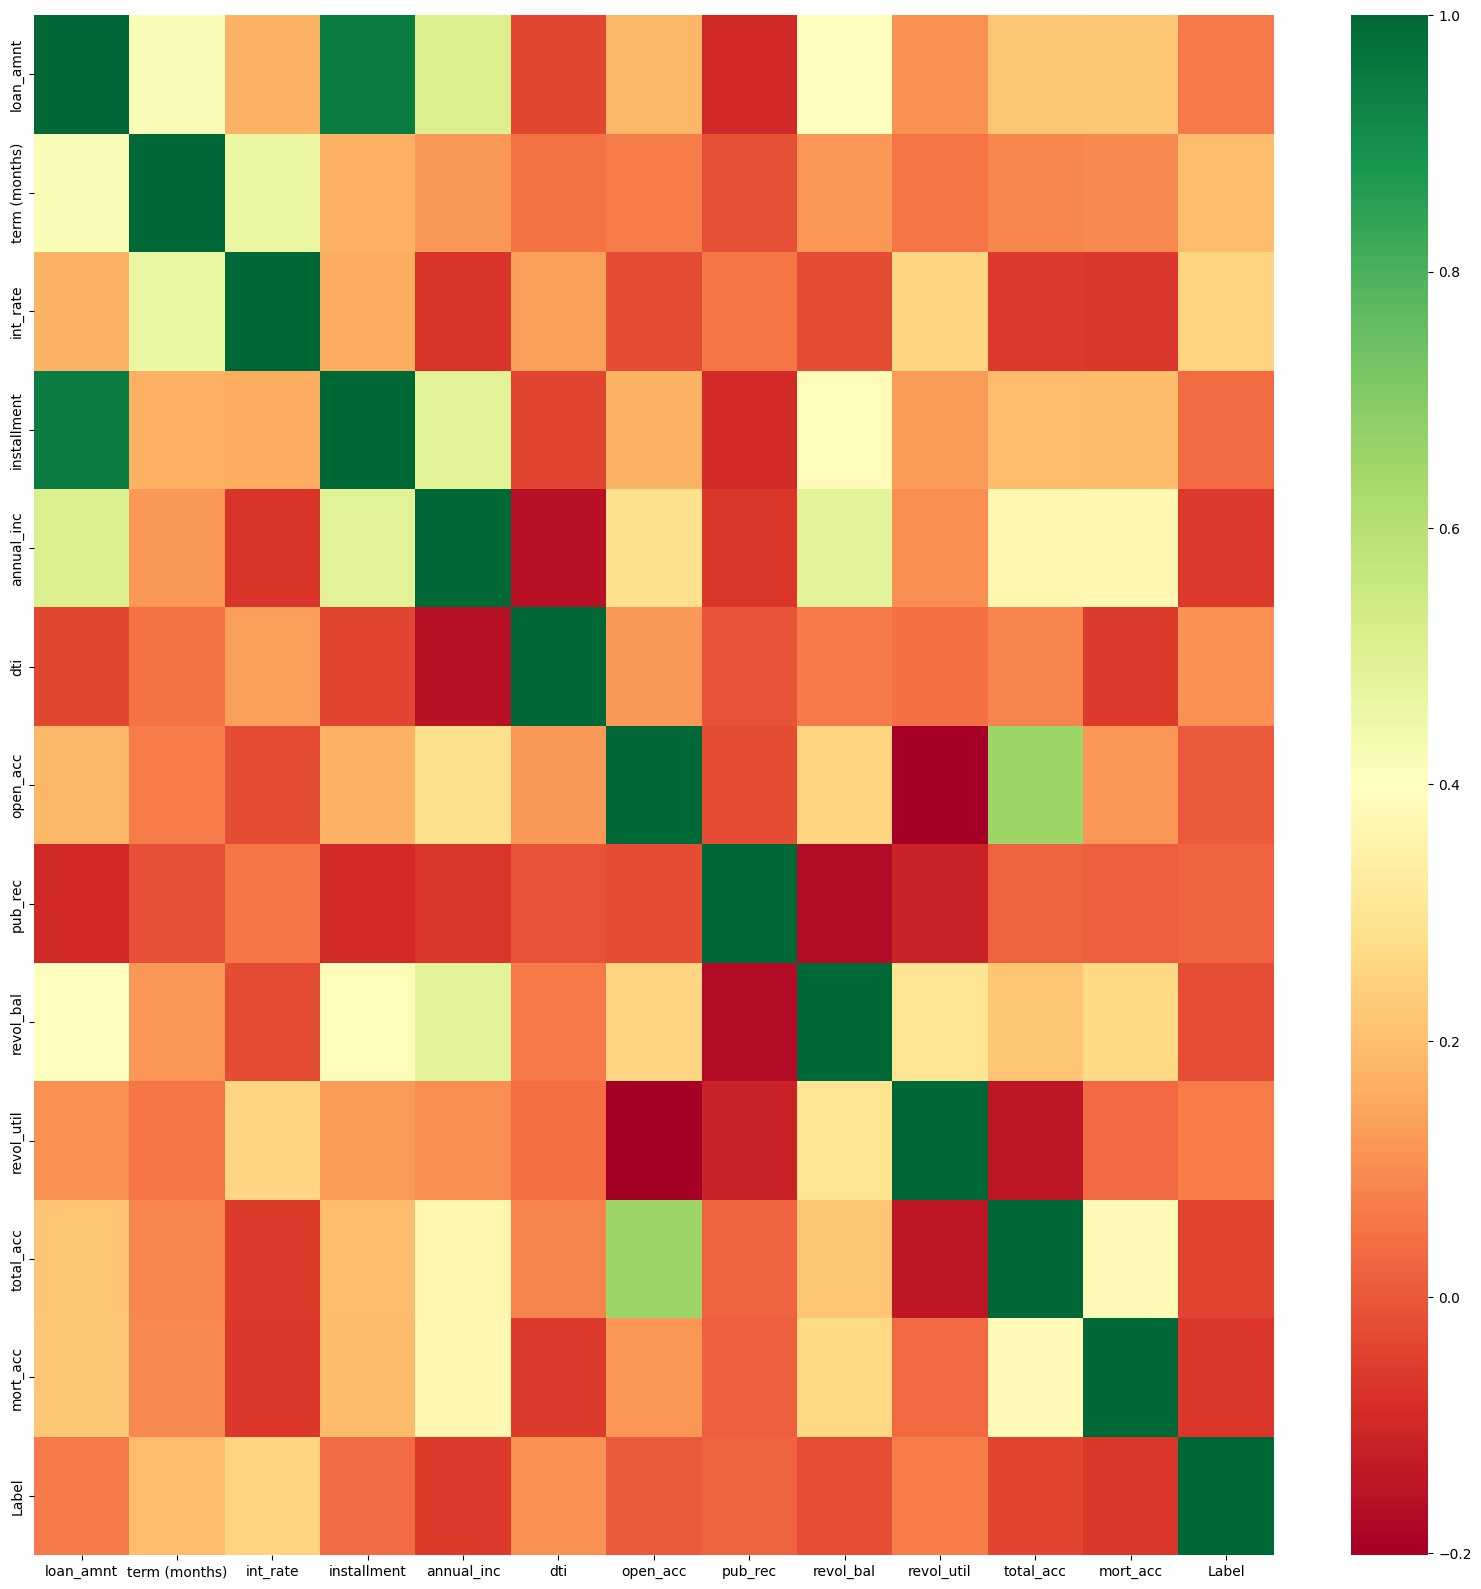

In [29]:
plt.figure(figsize = (20, 20))
sns.heatmap(robust_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

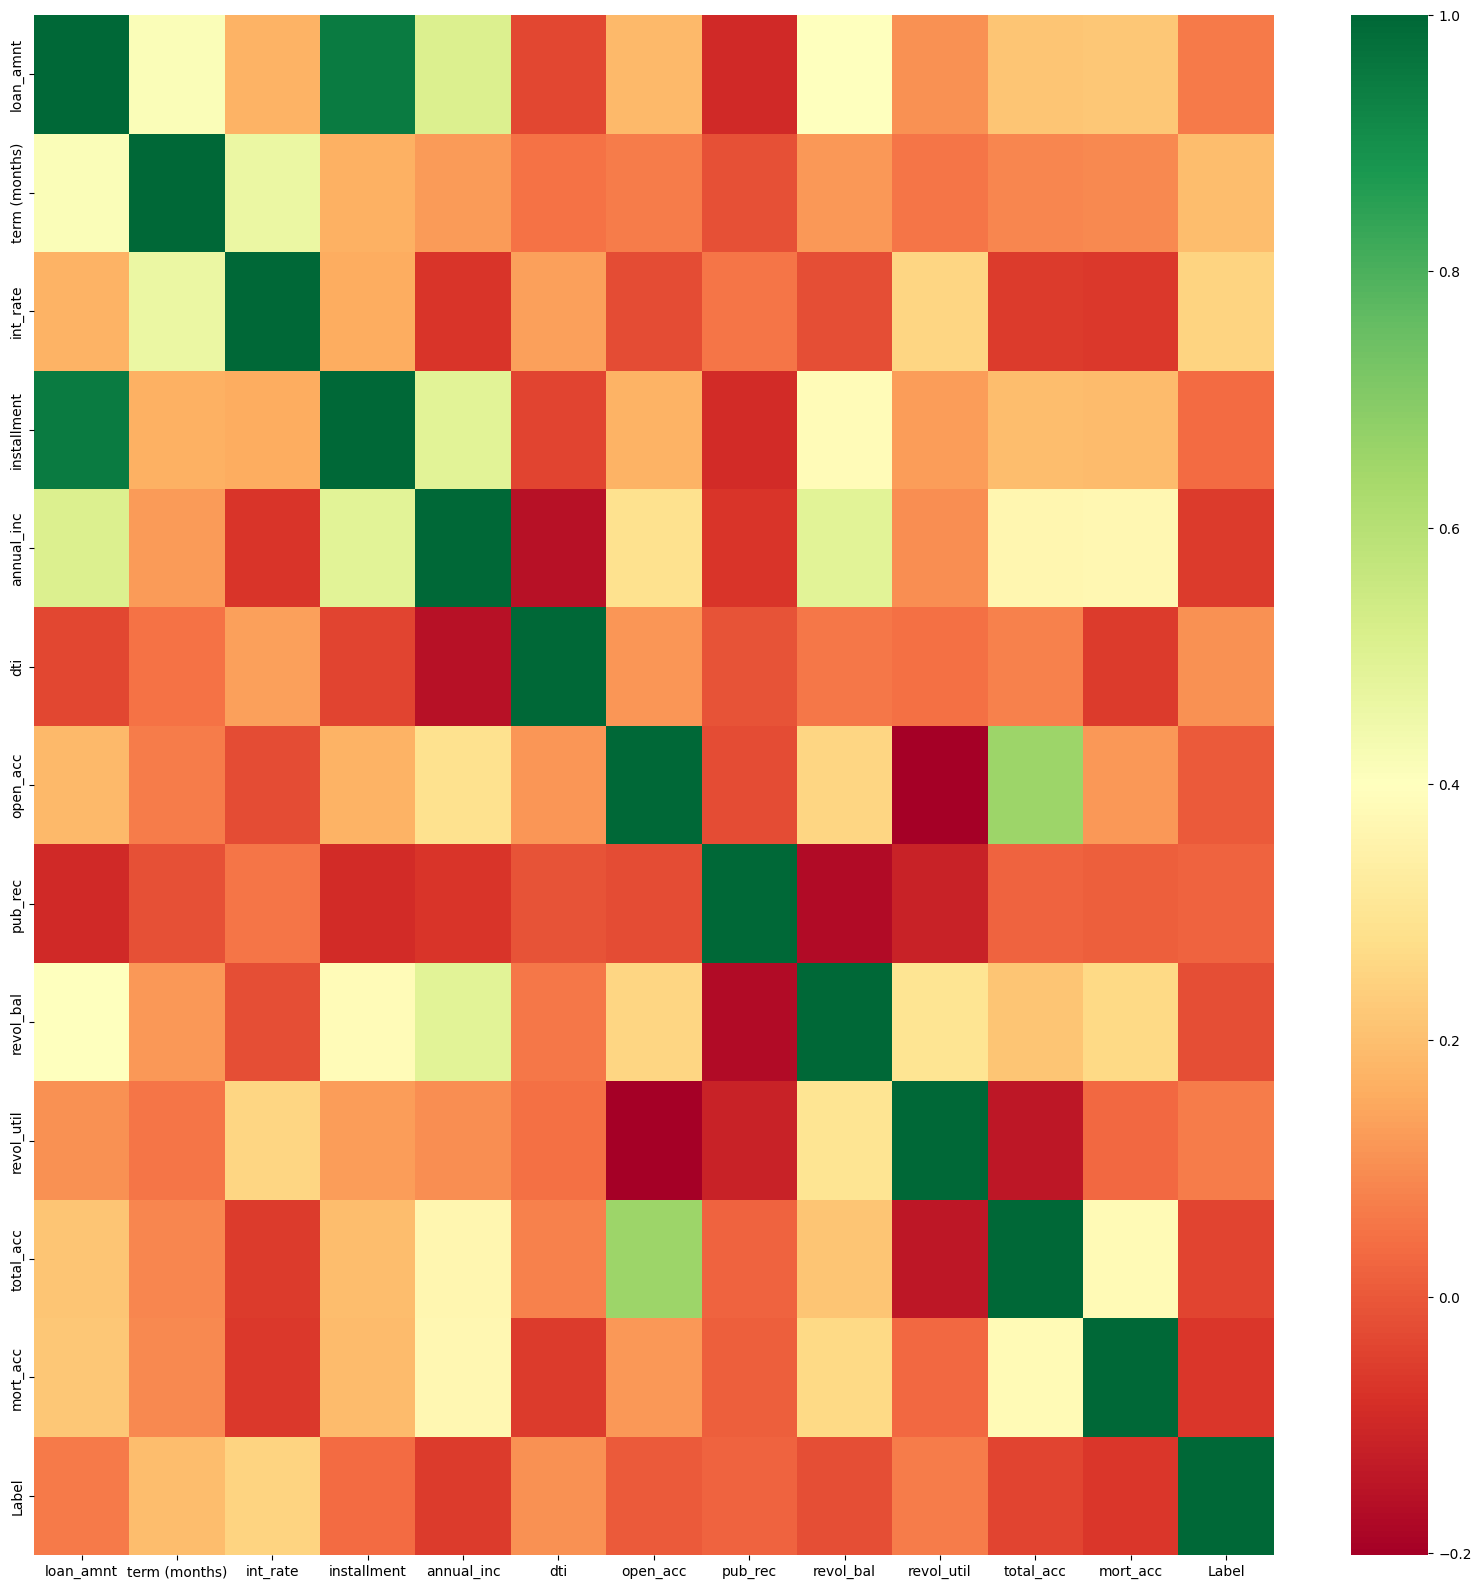

In [30]:
plt.figure(figsize = (20, 20))
sns.heatmap(standard_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

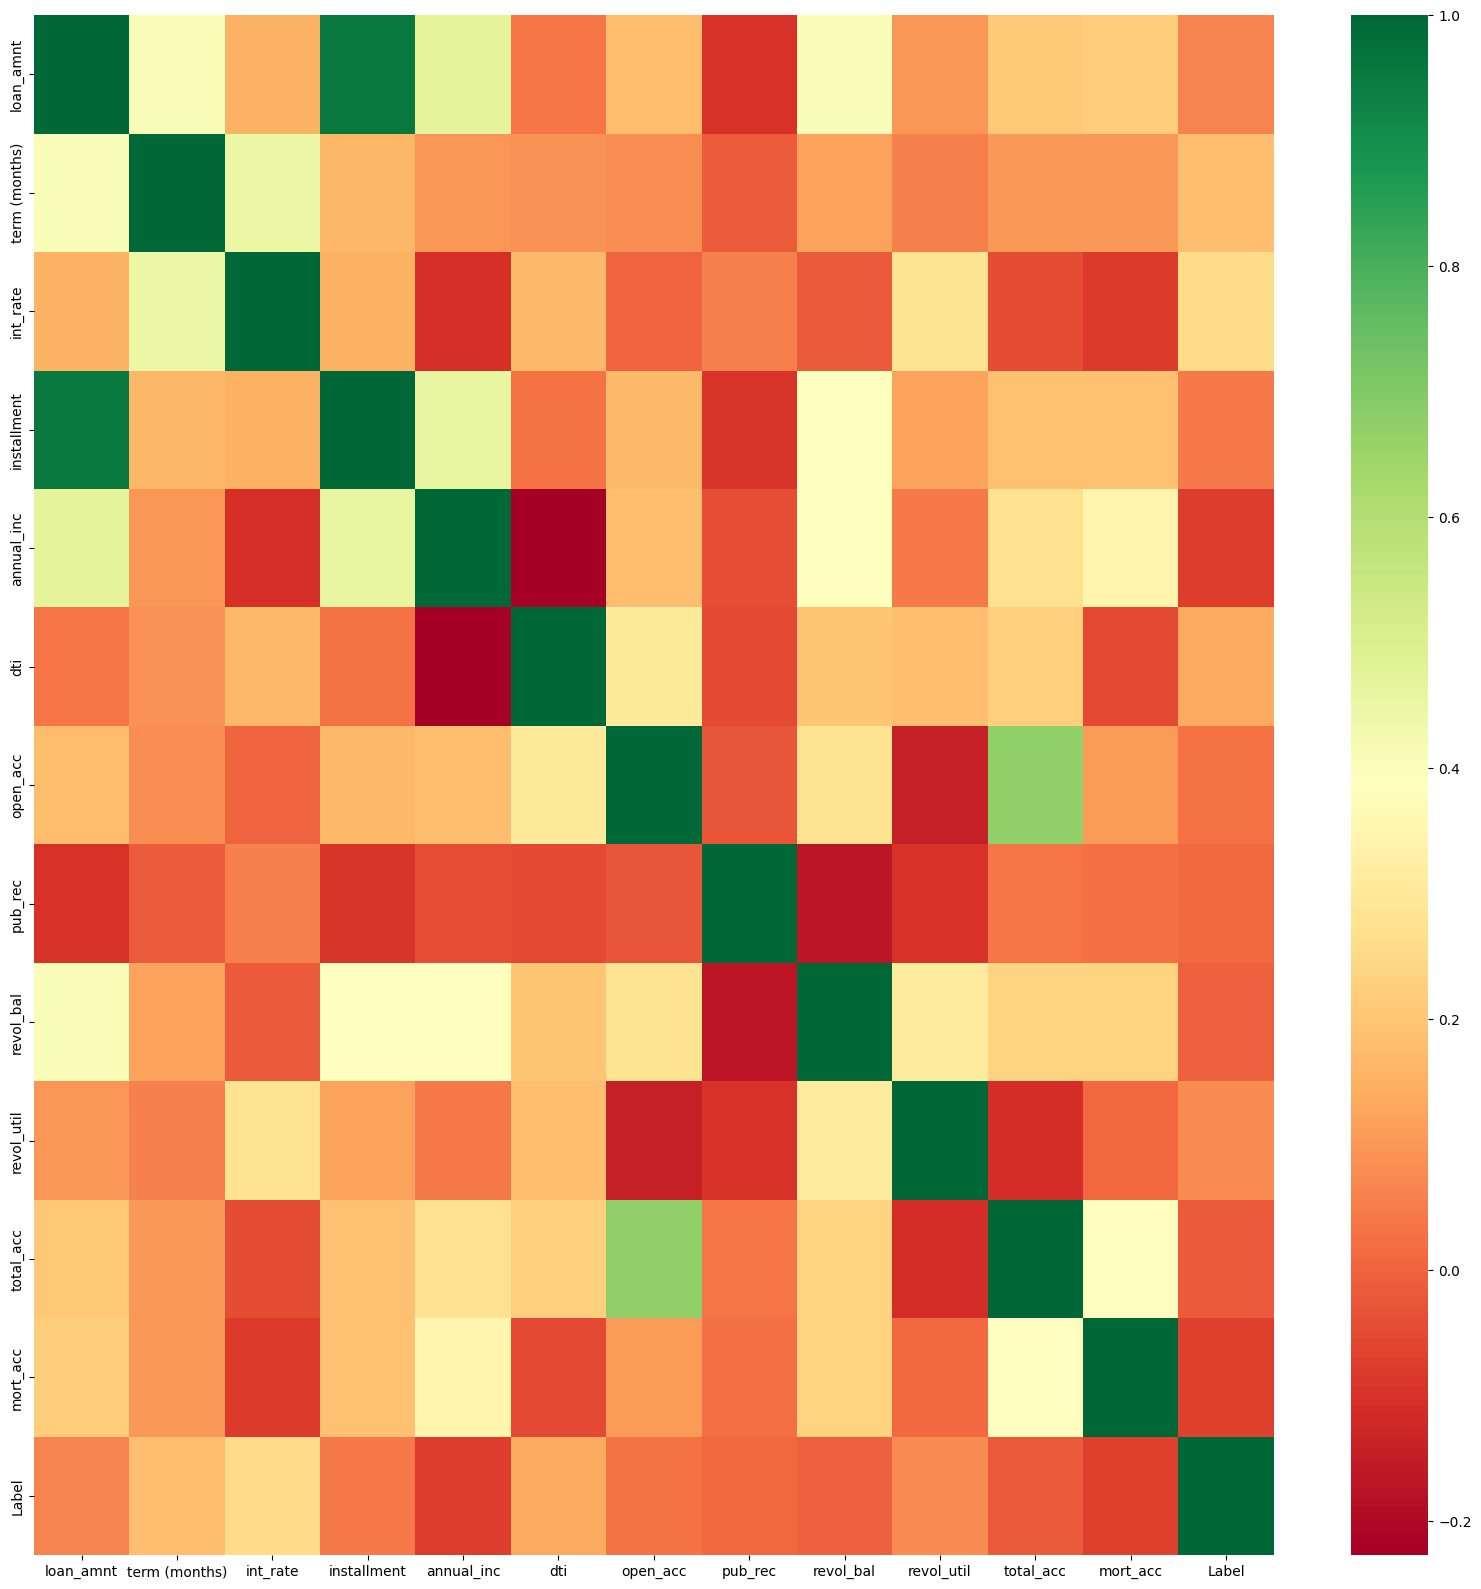

In [31]:
plt.figure(figsize = (20, 20))
sns.heatmap(minmax_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

In [32]:
X_train_robust  = robust_train_data.drop("Label", axis = 1)
y_train_robust = robust_train_data["Label"]
X_test_robust = robust_test_data.drop("Label", axis = 1)
y_test_robust = robust_test_data["Label"]

X_train_standard = standard_train_data.drop("Label", axis=1)
y_train_standard = standard_train_data["Label"]
X_test_standard = standard_test_data.drop("Label", axis=1)
y_test_standard = standard_test_data["Label"]

X_train_minmax = minmax_train_data.drop("Label", axis=1)
y_train_minmax = minmax_train_data["Label"]
X_test_minmax = minmax_test_data.drop("Label", axis=1)
y_test_minmax = minmax_test_data["Label"]

In [33]:
X_train_robust.shape

(111814, 75)

In [34]:
# from sklearn.preprocessing import PowerTransformer

# # Select only the specified numerical columns
# # selected_numerical_columns = [col for col in numerical_columns if col not in ['Label', 'mort_acc', 'pub_rec']]
# selected_numerical_columns = [col for col in numerical_columns if col not in ['Label']]

# # Apply Box-Cox Transform after handling zero values
# train_data_transformed = X_train[selected_numerical_columns].apply(lambda x: x + 0.000001 if (x <= 0).any() else x)
# pt = PowerTransformer(method='box-cox')
# train_data_transformed[selected_numerical_columns] = pt.fit_transform(train_data_transformed)

# # Replace original numerical columns in X_train with their normalized versions
# X_train[selected_numerical_columns] = train_data_transformed[selected_numerical_columns]


In [35]:
# pd.DataFrame({'cols':selected_numerical_columns,'box_cox_lambdas':pt.lambdas_})

In [36]:
# X_train.columns[X_train.isna().any()].tolist()

In [37]:
# X_test.shape,y_test.shape, X_train.shape, y_train.shape

In [38]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

The SGDClassifier estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the loss hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting loss = 'log'.

# Basic model with Preprocessed Data

In [39]:
basic_model_robust = SGDClassifier(loss='log_loss')


In [40]:
basic_model_robust.fit(X_train_robust, y_train_robust)

SGDClassifier(loss='log_loss')

In [41]:
y_train_pred_robust = basic_model_robust.predict(X_train_robust)
y_pred_robust = basic_model_robust.predict(X_test_robust)

y_probs_robust = basic_model_robust.predict_proba(X_test_robust)[:, 1]

In [42]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 86.42%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.849486      0.985938  0.864239       0.917712       0.882349
recall         0.997997      0.442608  0.864239       0.720303       0.864239
f1-score       0.917773      0.610949  0.864239       0.764361       0.843878
support    84885.000000  26929.000000  0.864239  111814.000000  111814.000000
_______________________________________________
Confusion Matrix: 
 [[84715   170]
 [15010 11919]]

Test Result:
Accuracy Score: 88.72%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.877582      0.988568  0.887165       0.933075       0.899469
recall         0.998770      0.432836  0.887165       0.715803       0.887165
f1-score       0.934262      0.602064  0.887165       0.76816

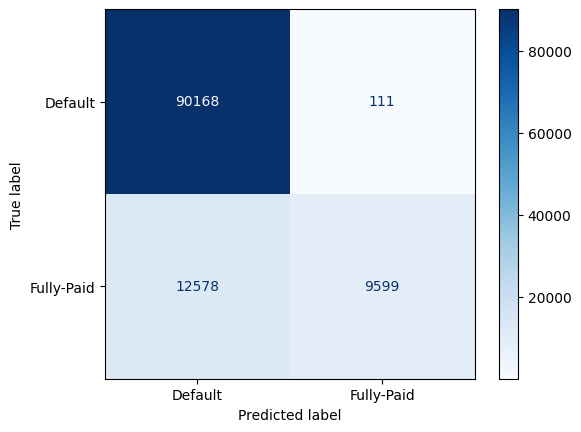

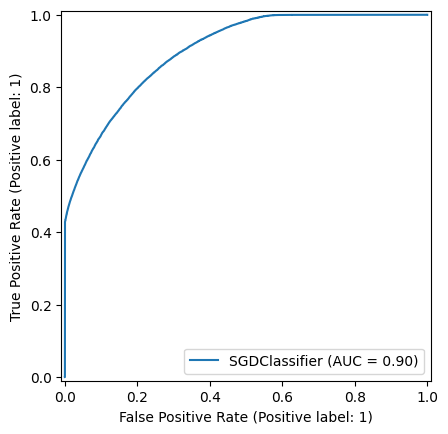

In [43]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(basic_model_robust, X_test_robust, y_test_robust)

In [44]:
basic_model_standard = SGDClassifier(loss='log_loss')

In [45]:
basic_model_standard.fit(X_train_standard, y_train_standard)

SGDClassifier(loss='log_loss')

In [46]:
y_train_pred_standard = basic_model_standard.predict(X_train_standard)
y_pred_standard = basic_model_standard.predict(X_test_standard)
y_probs_standard = basic_model_standard.predict_proba(X_test_standard)[:, 1]


In [47]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)


Train Result:
Accuracy Score: 86.44%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.856063      0.921977  0.864443       0.889020       0.872070
recall         0.986898      0.482667  0.864443       0.734783       0.864443
f1-score       0.916836      0.633624  0.864443       0.775230       0.848056
support    81212.000000  26049.000000  0.864443  107261.000000  107261.000000
_______________________________________________
Confusion Matrix: 
 [[80148  1064]
 [13476 12573]]

Test Result:
Accuracy Score: 88.77%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.881604      0.945061  0.887654       0.913333       0.894118
recall         0.993476      0.456870  0.887654       0.725173       0.887654
f1-score       0.934203      0.615964  0.887654       0.77508

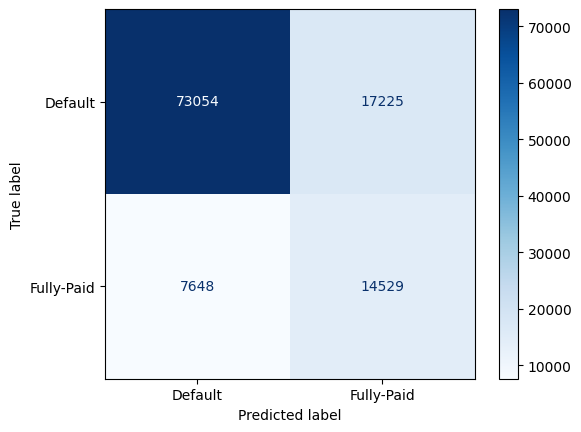

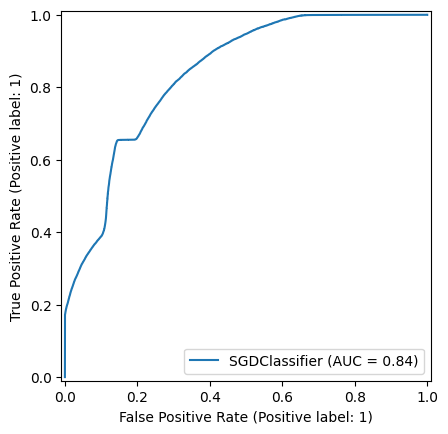

In [48]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_standard, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(basic_model_standard, X_test_robust, y_test_robust)

In [49]:
basic_model_minmax = SGDClassifier(loss='log_loss')

In [50]:
basic_model_minmax.fit(X_train_minmax, y_train_minmax)

SGDClassifier(loss='log_loss')

In [51]:
y_train_pred_minmax = basic_model_minmax.predict(X_train_minmax)
y_pred_minmax = basic_model_minmax.predict(X_test_minmax)
y_probs_minmax = basic_model_minmax.predict_proba(X_test_minmax)[:, 1]

In [52]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)


Train Result:
Accuracy Score: 88.84%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.883097      0.936865  0.888399       0.909981       0.893730
recall          0.992240      0.467151  0.888399       0.729695       0.888399
f1-score        0.934492      0.623436  0.888399       0.778964       0.872978
support    179374.000000  44217.000000  0.888399  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[177982   1392]
 [ 23561  20656]]

Test Result:
Accuracy Score: 88.82%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.882843      0.937232  0.888152       0.910038       0.893569
recall         0.992368      0.463904  0.888152       0.728136       0.888152
f1-score       0.934407      0.620619  0.888152     

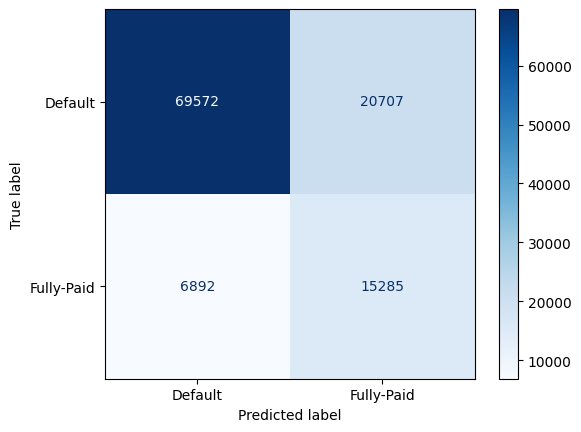

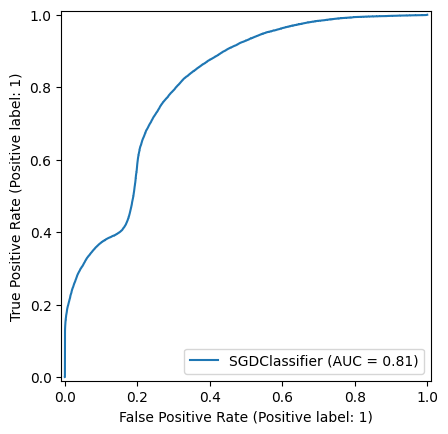

In [53]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    basic_model_minmax, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(basic_model_minmax, X_test_robust, y_test_robust)

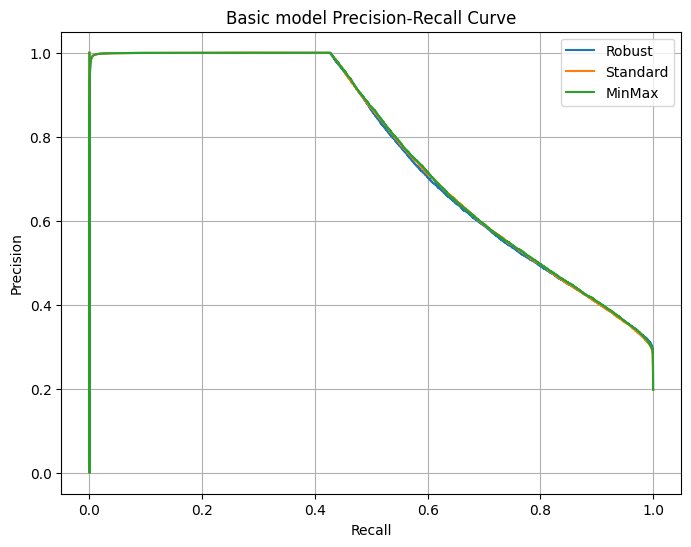

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# Model with Entire Data ( Tuning)

In [55]:
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced')

kf = StratifiedKFold(n_splits=5, shuffle=False)


In [56]:
param_grid_sgdlogreg = {
    'alpha': [10**-5, 10**-2, 10**1],
    'penalty': ['l1', 'l2']
}

In [57]:
grid_sgdlogreg_robust = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

grid_sgdlogreg_standard = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)


grid_sgdlogreg_minmax = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1_weighted',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=False)

In [58]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [59]:
grid_sgdlogreg_robust.best_score_

0.8167551479484455

In [60]:
grid_sgdlogreg_robust.best_params_

{'alpha': 1e-05, 'penalty': 'l2'}

In [61]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [62]:
grid_sgdlogreg_standard.best_score_

0.8081634293837279

In [63]:
grid_sgdlogreg_standard.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [64]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted', verbose=1)

In [65]:
grid_sgdlogreg_minmax.best_score_

0.8295470266826529

In [66]:
grid_sgdlogreg_minmax.best_params_

{'alpha': 0.01, 'penalty': 'l1'}

In [67]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)
y_probs_robust = grid_sgdlogreg_robust.predict_proba(X_test_robust)[:, 1]

In [68]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 77.68%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.935229      0.522911  0.776772       0.729070       0.835928
recall         0.758485      0.834416  0.776772       0.796451       0.776772
f1-score       0.837635      0.642918  0.776772       0.740277       0.790740
support    84885.000000  26929.000000  0.776772  111814.000000  111814.000000
_______________________________________________
Confusion Matrix: 
 [[64384 20501]
 [ 4459 22470]]

Test Result:
Accuracy Score: 80.88%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.935523      0.510060  0.808787       0.722791       0.851619
recall         0.818208      0.770438  0.808787       0.794323       0.808787
f1-score       0.872941      0.613776  0.808787       0.74335

In [69]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)
y_probs_standard = grid_sgdlogreg_standard.predict_proba(X_test_standard)[:, 1]

In [70]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 79.70%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.900794      0.564539  0.796991       0.732666       0.819133
recall         0.822452      0.717609  0.796991       0.770031       0.796991
f1-score       0.859843      0.631937  0.796991       0.745890       0.804494
support    81212.000000  26049.000000  0.796991  107261.000000  107261.000000
_______________________________________________
Confusion Matrix: 
 [[66793 14419]
 [ 7356 18693]]

Test Result:
Accuracy Score: 83.60%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.912547      0.573527  0.835998       0.743037       0.845690
recall         0.880050      0.656671  0.835998       0.768360       0.835998
f1-score       0.896004      0.612290  0.835998       0.75414

In [71]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)
y_probs_minmax = grid_sgdlogreg_minmax.predict_proba(X_test_minmax)[:, 1]

In [72]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 82.19%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.913496      0.540148  0.821934       0.726822       0.839664
recall          0.859422      0.669855  0.821934       0.764639       0.821934
f1-score        0.885635      0.598050  0.821934       0.741842       0.828762
support    179374.000000  44217.000000  0.821934  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[154158  25216]
 [ 14598  29619]]

Test Result:
Accuracy Score: 82.00%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.912604      0.534996  0.819965       0.723800       0.838138
recall         0.857896      0.665554  0.819965       0.761725       0.819965
f1-score       0.884405      0.593176  0.819965     

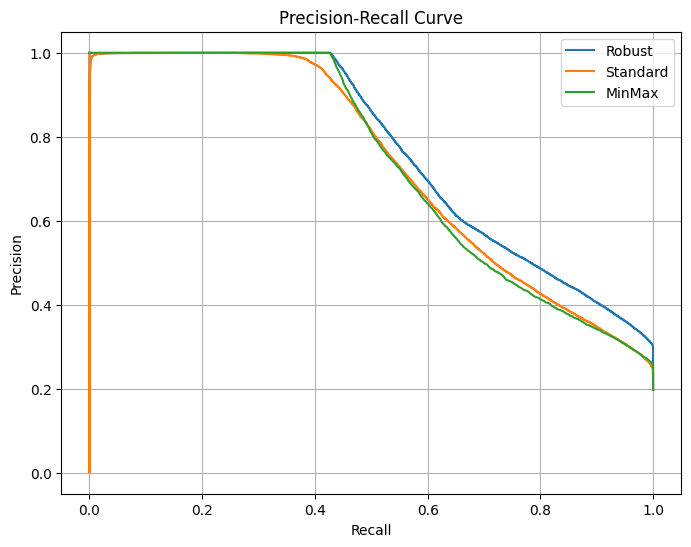

In [73]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


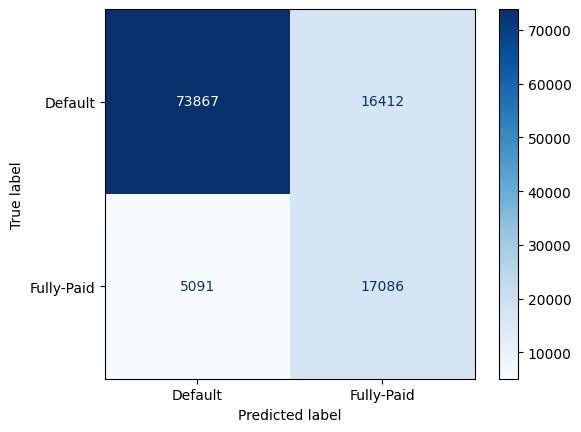

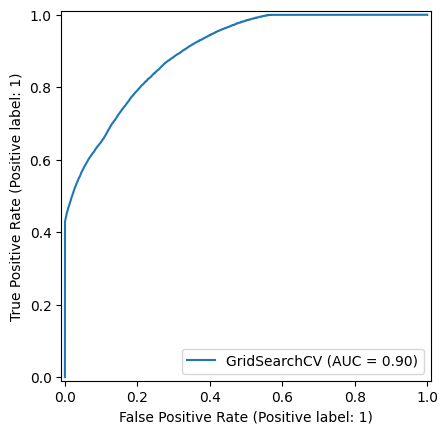

In [74]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

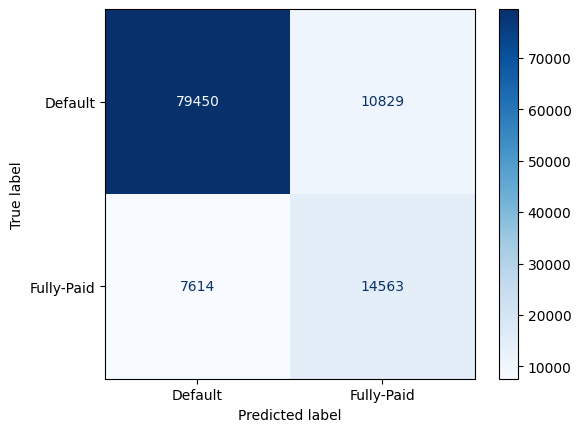

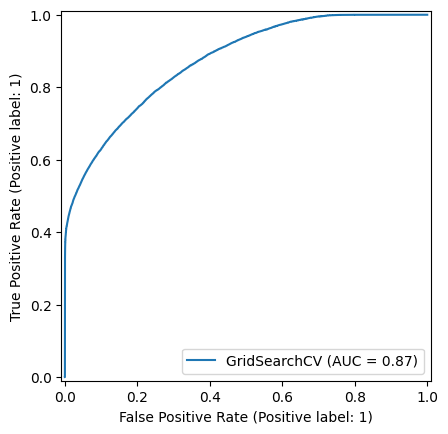

In [75]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

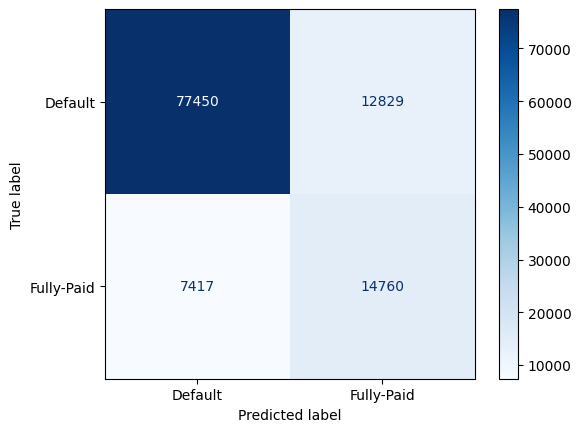

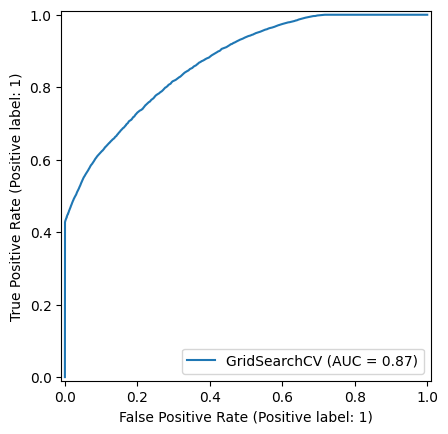

In [76]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

## With undersampling

In [77]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [78]:
rus = RandomUnderSampler(random_state=42)

In [79]:
X_under_robust, y_under_robust = rus.fit_resample(X_train_robust, y_train_robust)
X_under_minmax, y_under_minmax = rus.fit_resample(X_train_minmax, y_train_minmax)
X_under_standard, y_under_standard = rus.fit_resample(X_train_standard, y_train_standard)

In [80]:
print('Fully Paid:', y_under_robust.value_counts()[0], '/', round(y_under_robust.value_counts()[0]/len(y_under_robust) * 100,2), '% of the dataset')
print('Charged Off:', y_under_robust.value_counts()[1], '/',round(y_under_robust.value_counts()[1]/len(y_under_robust) * 100,2), '% of the dataset')




Fully Paid: 26929 / 50.0 % of the dataset
Charged Off: 26929 / 50.0 % of the dataset


In [81]:
param_grid_sgdlogreg = {
    'sgdclassifier__alpha': [0.00001, 0.001, 10],
    'sgdclassifier__penalty': ['l1', 'l2'],
}

In [82]:
pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                       SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced'))



In [83]:
grid_sgdlogreg_robust = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

grid_sgdlogreg_standard = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)


grid_sgdlogreg_minmax = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='f1',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

In [84]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [85]:
grid_sgdlogreg_robust.best_score_

0.6540713194163988

In [86]:
grid_sgdlogreg_robust.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [87]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)
y_probs_robust = grid_sgdlogreg_robust.predict_proba(X_test_robust)[:, 1]

In [88]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 80.21%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.922372      0.563959  0.802091       0.743165       0.836053
recall         0.807245      0.785844  0.802091       0.796545       0.802091
f1-score       0.860977      0.656665  0.802091       0.758821       0.811771
support    84885.000000  26929.000000  0.802091  111814.000000  111814.000000
_______________________________________________
Confusion Matrix: 
 [[68523 16362]
 [ 5767 21162]]

Test Result:
Accuracy Score: 84.13%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.924203      0.579921  0.841289       0.752062       0.856309
recall         0.873980      0.708211  0.841289       0.791095       0.841289
f1-score       0.898390      0.637678  0.841289       0.76803

In [89]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [90]:
grid_sgdlogreg_standard.best_score_

0.6605648592895687

In [91]:
grid_sgdlogreg_standard.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l1'}

In [92]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)
y_probs_standard = grid_sgdlogreg_standard.predict_proba(X_test_standard)[:, 1]

In [93]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 81.47%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.913297      0.593423  0.814723       0.753360       0.835613
recall         0.834520      0.753004  0.814723       0.793762       0.814723
f1-score       0.872133      0.663756  0.814723       0.767945       0.821527
support    81212.000000  26049.000000  0.814723  107261.000000  107261.000000
_______________________________________________
Confusion Matrix: 
 [[67773 13439]
 [ 6434 19615]]

Test Result:
Accuracy Score: 84.97%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.918447      0.606343  0.849666       0.762395       0.856898
recall         0.891935      0.677594  0.849666       0.784764       0.849666
f1-score       0.904997      0.639991  0.849666       0.77249

In [94]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='f1', verbose=1)

In [95]:
grid_sgdlogreg_minmax.best_score_

0.6251966493672958

In [96]:
grid_sgdlogreg_minmax.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [97]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)
y_probs_minmax = grid_sgdlogreg_minmax.predict_proba(X_test_minmax)[:, 1]

In [98]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 81.60%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.938963      0.523310   0.81603       0.731137       0.856764
recall          0.824261      0.782640   0.81603       0.803451       0.816030
f1-score        0.877881      0.627227   0.81603       0.752554       0.828312
support    179374.000000  44217.000000   0.81603  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[147851  31523]
 [  9611  34606]]

Test Result:
Accuracy Score: 81.44%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.936415      0.519747  0.814363       0.728081       0.854245
recall         0.824765      0.772016  0.814363       0.798391       0.814363
f1-score       0.877051      0.621249  0.814363     

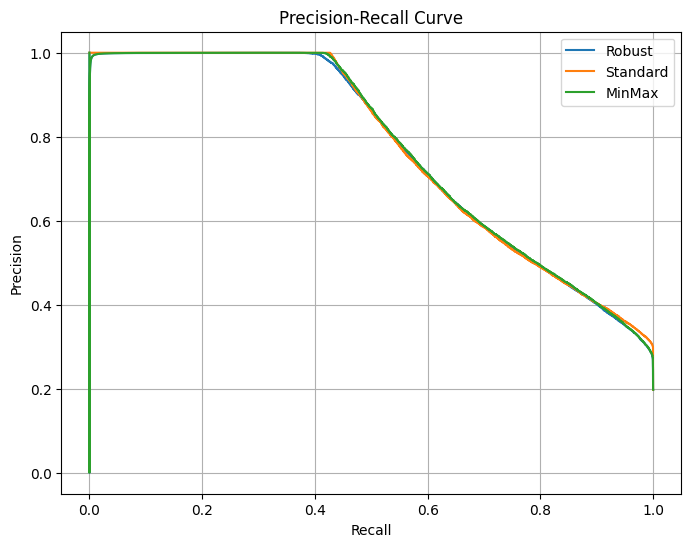

In [99]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_probs_robust, y_probs_standard, y_probs_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


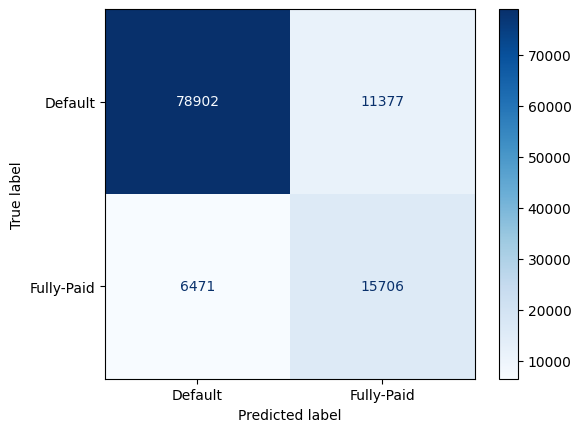

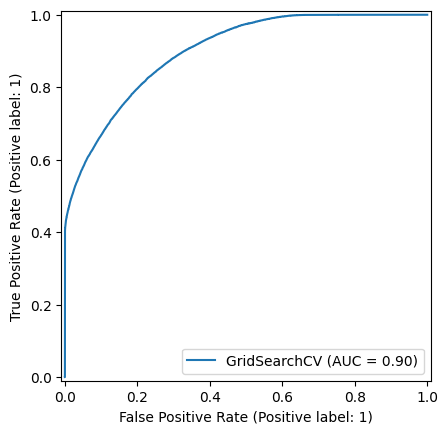

In [100]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

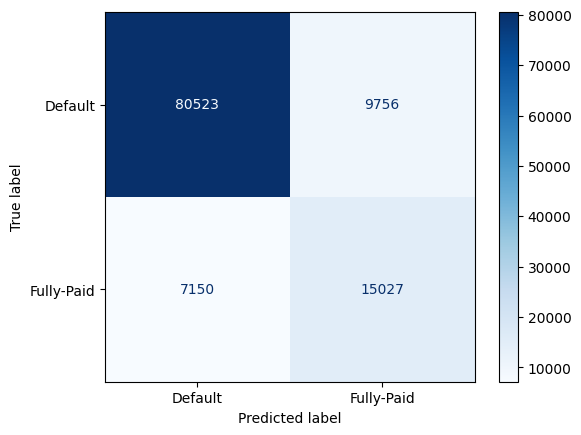

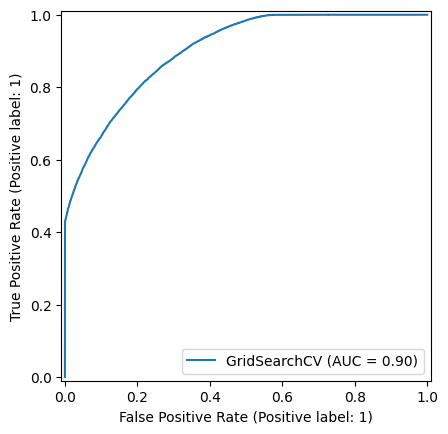

In [101]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

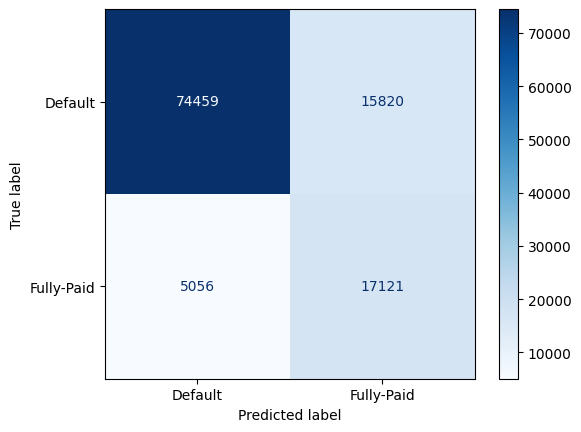

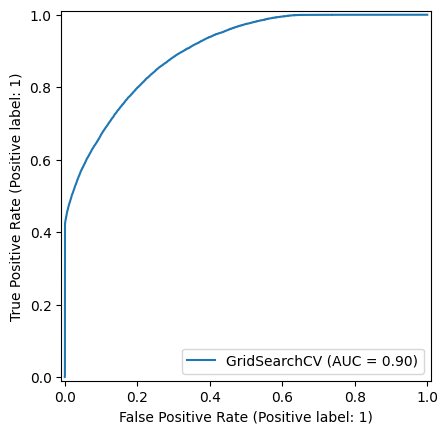

In [102]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)